# Machine Learning - Exercise 8
# Regularization in ANNs

This exercise illustrates the effects of applying regularization in ANNs.

##Import 

Import libraries that contains the implementations of the functions used in the rest of the program.



In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import tensorflow.keras as keras

import random
import numpy as np
import sklearn.metrics 
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

# fix random seed
tf.set_random_seed(123)
np.random.seed(123)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

print("Libraries imported.")

Libraries imported.


## Load data

Load the dataset.

More details on the MNIST dataset are available in http://yann.lecun.com/exdb/mnist/

More details on the Fashion-MNIST dataset are available in https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/

### MNIST dataset

In [ ]:
DB = keras.datasets.mnist
dataset_name = 'MNIST'

### Fashion-MNIST dataset

In [ ]:
DB = keras.datasets.fashion_mnist
dataset_name = 'FASHION_MNIST'

### Load and data split

In [ ]:
(X_train, y_train), (X_test, y_test) = DB.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

###Summary of the dataset

Print some information about the dataset

In [ ]:
class_names = np.array(range(10))
print(X_train.shape)
print(y_train.shape)

ninput = X_train.shape[1]
nsamples = X_train.shape[0]

print("Dataset: %s" %(dataset_name))
print("Number of attributes/features: %d" %(ninput))
print("Number of classes: %d %s" %(len(class_names), str(class_names)))
print("Number of samples: %d" %(nsamples))

(60000, 28, 28)
(60000,)
Dataset: FASHION_MNIST
Number of attributes/features: 28
Number of classes: 10 [0 1 2 3 4 5 6 7 8 9]
Number of samples: 60000


### Show an example

Display a random sample.

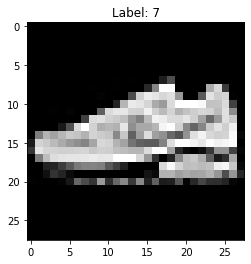

In [ ]:
id = random.randrange(0,X_train.shape[0])
plt.imshow(X_train[id],cmap='gray')
plt.title('Label: {}'.format(y_train[id]))
plt.show()

##Create ANN Models

Model fitting = finding a solution that is stored in the model.

IMPORTANT: solution depends on data split

**1st model** - No regularization (baseline)

In [ ]:
models = []
titles = ['Baseline', 'Weight Decay', 'Dropout']

model_tmp = keras.models.Sequential([
  keras.layers.Flatten(input_shape=(28, 28)),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(len(class_names), activation='softmax')
])
Wsave = model_tmp.get_weights() # save the initialized weights 
print(model_tmp.summary())
models.append(model_tmp)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________
None


**2nd model** - Weight decay

In [ ]:
model_tmp = keras.models.Sequential([
  keras.layers.Flatten(input_shape=(28, 28)),
  keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
  keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
  keras.layers.Dense(len(class_names), activation='softmax')
])
model_tmp.set_weights(Wsave) # use the same initialized weights
print(model_tmp.summary())
models.append(model_tmp)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________
None


**3rd model** - Dropout

In [ ]:
model_tmp = keras.models.Sequential([
  keras.layers.Flatten(input_shape=(28, 28)),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(len(class_names), activation='softmax')
])
model_tmp.set_weights(Wsave) # use the same initialized weights
print(model_tmp.summary())
models.append(model_tmp)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________
None


### Define optimizer and compile the models

In [ ]:
optimizers = [keras.optimizers.SGD(lr = 0.01, momentum = 1.0), 'adadelta', 'adam']

for m in models:
  m.compile(optimizer=optimizers[2],
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Fit the model

Using validation data

In [ ]:
nepochs = 20
batch_size = 128

histories = []
for i,m in enumerate(models):
  print('Training {} model'.format(titles[i]))
  histories.append(m.fit(X_train, y_train, batch_size=batch_size, epochs=nepochs, validation_data=(X_test,y_test)))

Training Baseline model
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 27us/sample - loss: 0.6030 - acc: 0.7948 - val_loss: 0.4609 - val_acc: 0.8386
Epoch 2/20
60000/60000 [==============================] - 1s 21us/sample - loss: 0.4165 - acc: 0.8531 - val_loss: 0.4180 - val_acc: 0.8511
Epoch 3/20
60000/60000 [==============================] - 1s 22us/sample - loss: 0.3805 - acc: 0.8635 - val_loss: 0.4009 - val_acc: 0.8570
Epoch 4/20
60000/60000 [==============================] - 1s 21us/sample - loss: 0.3554 - acc: 0.8727 - val_loss: 0.3939 - val_acc: 0.8596
Epoch 5/20
60000/60000 [==============================] - 1s 21us/sample - loss: 0.3393 - acc: 0.8770 - val_loss: 0.3832 - val_acc: 0.8650
Epoch 6/20
60000/60000 [==============================] - 1s 21us/sample - loss: 0.3236 - acc: 0.8839 - val_loss: 0.3734 - val_acc: 0.8670
Epoch 7/20
60000/60000 [==============================] - 1s 21us/sample - loss: 0.3108 - ac

## Loss and Accuracy Plots

### Loss comparison

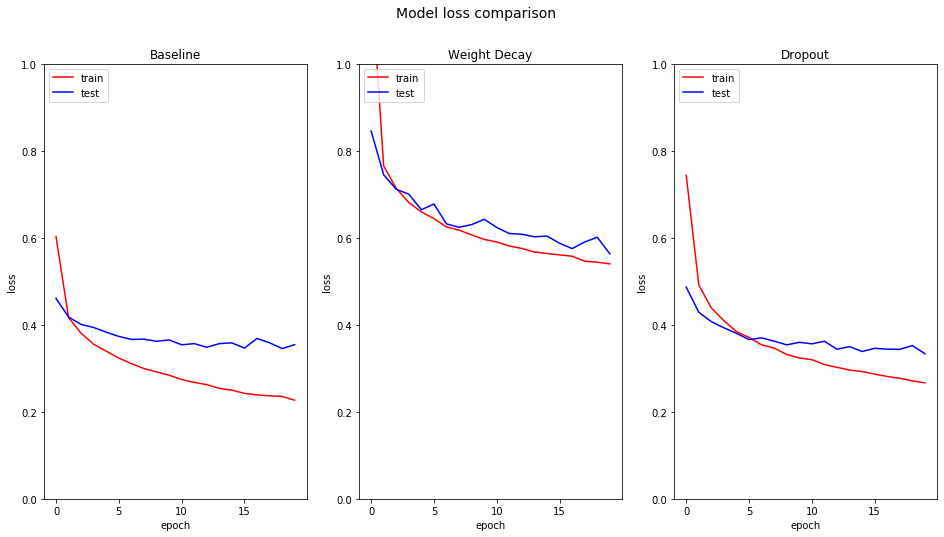

In [ ]:
fig=plt.figure(figsize=(16, 8))
for i,h in enumerate(histories):
  plt.subplot(1,3,i+1)
  plt.plot(h.history['loss'],'r')
  plt.plot(h.history['val_loss'],'b')
  plt.ylim((0.,1.))
  plt.title(titles[i])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
plt.suptitle('Model loss comparison', fontsize=14)
plt.show()

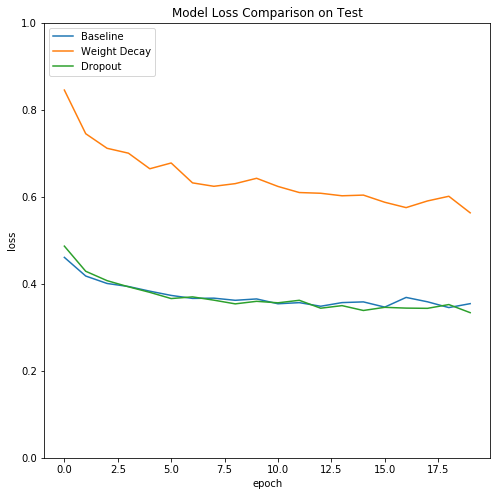

In [ ]:
fig=plt.figure(figsize=(8, 8))
for h in histories:
  plt.plot(h.history['val_loss'])
  plt.ylim((0.,1.))
  plt.title('Model Loss Comparison on Test')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(titles, loc='upper left')
plt.show()

### Accuracy comparison

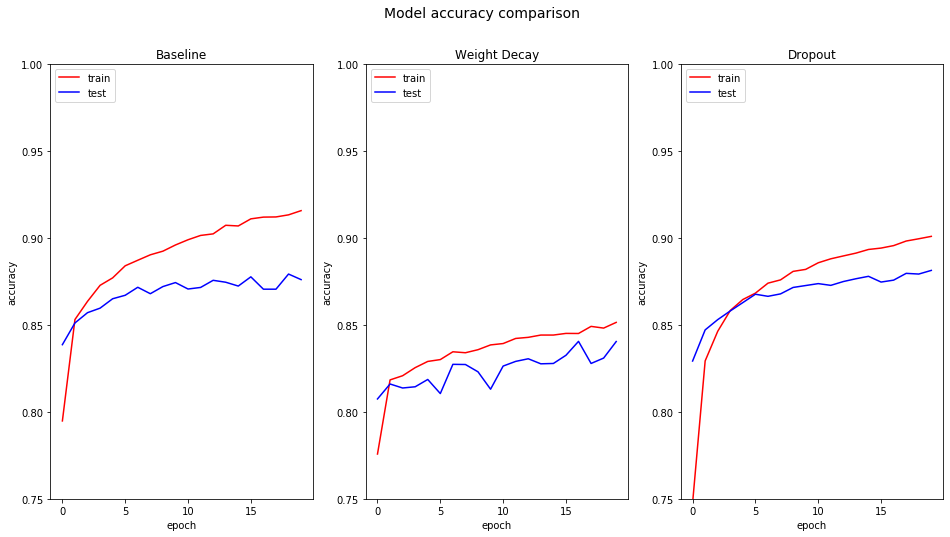

In [ ]:
fig=plt.figure(figsize=(16, 8))
for i,h in enumerate(histories):
  plt.subplot(1,3,i+1)
  plt.plot(h.history['acc'],'r')
  plt.plot(h.history['val_acc'],'b')
  plt.ylim((0.75,1.))
  plt.title(titles[i])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
plt.suptitle('Model accuracy comparison', fontsize=14)
plt.show()

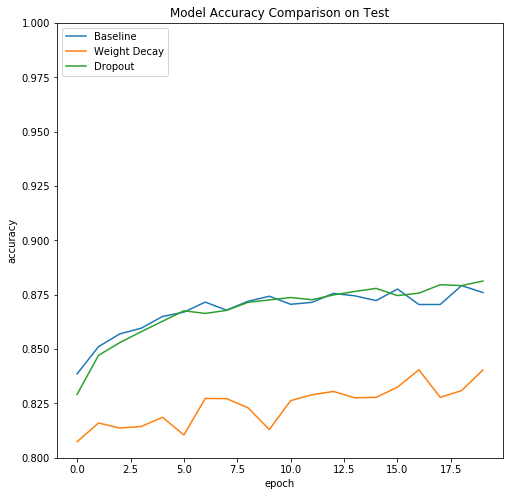

In [ ]:
fig=plt.figure(figsize=(8, 8))
for h in histories:
  plt.plot(h.history['val_acc'])
  plt.ylim((0.8,1.))
  plt.title('Model Accuracy Comparison on Test')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(titles, loc='upper left')
plt.show()

##Predict on test set

Use test set for prediction.

In [ ]:
model = models[2]
y_pred_sm = model.predict(X_test)
y_pred = np.argmax(y_pred_sm, axis=1)

##Evaluate the Model

Evaluation of a specific solution.

### Accuracy

In [ ]:
acc = model.evaluate(X_test, y_test)
print("Accuracy %.3f" %acc[-1])

10000/10000 [==============================] - 0s 50us/sample - loss: 0.3337 - acc: 0.8813
Accuracy 0.881


###Precision & Recall

In [ ]:
print(classification_report(y_test, y_pred, labels=None, digits=3))

              precision    recall  f1-score   support

           0      0.843     0.819     0.831      1000
           1      0.992     0.971     0.981      1000
           2      0.771     0.809     0.790      1000
           3      0.871     0.914     0.892      1000
           4      0.797     0.811     0.804      1000
           5      0.963     0.965     0.964      1000
           6      0.708     0.656     0.681      1000
           7      0.962     0.927     0.944      1000
           8      0.965     0.972     0.969      1000
           9      0.937     0.969     0.953      1000

    accuracy                          0.881     10000
   macro avg      0.881     0.881     0.881     10000
weighted avg      0.881     0.881     0.881     10000



### Confusion Matrix

[[819   2  21  29   3   1 114   0  11   0]
 [  1 971   2  21   2   0   2   0   1   0]
 [ 10   0 809  14  96   0  70   0   1   0]
 [ 12   5  15 914  26   0  22   0   6   0]
 [  0   1 102  31 811   0  54   0   1   0]
 [  0   0   0   1   0 965   0  16   4  14]
 [128   0  96  36  73   0 656   0  11   0]
 [  0   0   0   0   0  22   0 927   0  51]
 [  2   0   4   3   6   3   8   2 972   0]
 [  0   0   0   0   0  11   1  19   0 969]]


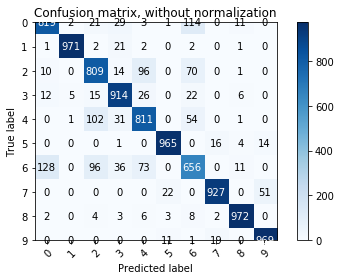

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
print(cm)
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=False)